# 14. Deep learning MRI reconstructoion: Simple UNet model.

This model is a simplified version of the U-Net architecture,
which is widely used for image segmentation tasks.
This is implemented in the proprietary FASTMRI package [fastmri]_.

The U-Net model consists of an encoder (downsampling path) and
a decoder (upsampling path) with skip connections between corresponding
layers in the encoder and decoder.
These skip connections help in retaining spatial information
that is lost during the downsampling process.

The primary purpose of this model is to perform image reconstruction tasks,
specifically for MRI images.
It takes an input MRI image and reconstructs it to improve the image quality
or to recover missing parts of the image.

This implementation of the UNet model was pulled from the FastMRI Facebook
repository, which is a collaborative research project aimed at advancing
the field of medical imaging using machine learning techniques.

$$\mathbf{\hat{x}} = \mathrm{arg} \min_{\mathbf{x}} || \mathcal{U}_\mathbf{\theta}(\mathbf{y}) - \mathbf{x} ||_2^2$$

where $\mathbf{\hat{x}}$ is the reconstructed MRI image, $\mathbf{x}$ is the ground truth image,
$\mathbf{y}$ is the input MRI image (e.g., k-space data), and $\mathcal{U}_\mathbf{\theta}$ is the U-Net model parameterized by $\theta$.

.. warning::
    We train on a single image here. In practice, this should be done on a database like fastMRI [fastmri]_.
"""
# %%
# .. colab-link::
#    :needs_gpu: 1
#
#    !pip install mri-nufft[gpunufft] scikit-image fastmri

- Author: Zaccharie Ramzi, Chaithya G R, Pierre-Antoine Comby
- Date: 01/07/2021
- Target: ATSI MSc students, Paris-Saclay University

## Install dependencies

***On Google Colab, it is required to install the following dependencies in order for the notebook to work***

In [ ]:
!pip install mri-nufft[finufft,gpunufft] pyWavelets pysap-mri brainweb-dl "numpy<2.0" python-pysap 

In [ ]:
# We will also dowload extra data if needed:

In [1]:
# Package import
from mri.operators import FFT, WaveletN, OWL
from mri.reconstructors import CalibrationlessReconstructor
from pysap.data import get_sample_data

# Third party import
from modopt.opt.proximity import GroupLASSO
from modopt.math.metrics import ssim
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# Loading input data
cartesian_ref_image = get_sample_data('2d-pmri').data
image = np.linalg.norm(cartesian_ref_image, axis=0)
# Obtain MRI cartesian mask
mask = get_sample_data("cartesian-mri-mask").data

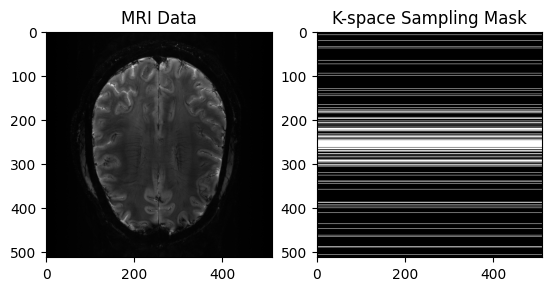

In [3]:
# View Input
plt.subplot(1, 2, 1)
plt.imshow(np.abs(image), cmap='gray')
plt.title("MRI Data")
plt.subplot(1, 2, 2)
plt.imshow(mask, cmap='gray')
plt.title("K-space Sampling Mask")
plt.show()

## Generate the kspace

From the 2D brain slice and the acquisition mask, we retrospectively
undersample the k-space using a cartesian acquisition mask
We then reconstruct the zero order solution as a baseline

In [4]:
# Get the locations of the kspace samples and the associated observations
fourier_op = FFT(mask=mask, shape=image.shape,
                 n_coils=cartesian_ref_image.shape[0])
kspace_obs = fourier_op.op(cartesian_ref_image)

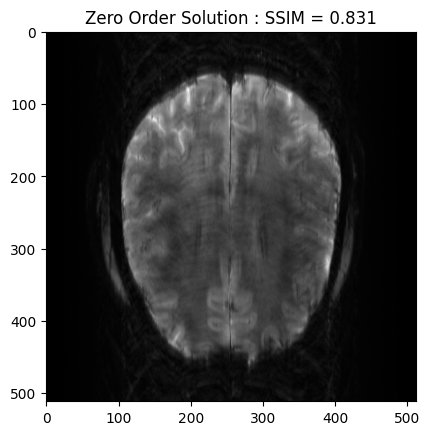

In [5]:
# Zero order solution
zero_soln = np.linalg.norm(fourier_op.adj_op(kspace_obs), axis=0)
base_ssim = ssim(zero_soln, image)
plt.imshow(np.abs(zero_soln), cmap='gray')
plt.title('Zero Order Solution : SSIM = ' + str(np.around(base_ssim, 3)))
plt.show()

## Synthesis formulation: FISTA vs POGM optimization

We now want to refine the zero order solution using a FISTA optimization.
The cost function is set to Proximity Cost + Gradient Cost

In [6]:
# Setup the operators
linear_op = WaveletN(
    wavelet_name='sym8',
    nb_scale=4,
    n_coils=cartesian_ref_image.shape[0],
)
coeffs = linear_op.op(cartesian_ref_image)
regularizer_op = GroupLASSO(weights=6e-8)

## Setup reconstructor:

In [7]:
# Setup Reconstructor
reconstructor = CalibrationlessReconstructor(
    fourier_op=fourier_op,
    linear_op=linear_op,
    regularizer_op=regularizer_op,
    gradient_formulation='synthesis',
    verbose=1,
)

Lipschitz constant is 1.1


 - mu:  6e-08
 - lipschitz constant:  1.1
 - data:  (512, 512)
 - wavelet:  <mri.operators.linear.wavelet.WaveletN object at 0x795b2c947df0> - 4
 - max iterations:  100
 - image variable shape:  (512, 512)
 - alpha variable shape:  (32, 291721)
----------------------------------------
Starting optimization...


  0%|          | 0/100 [00:00<?, ?it/s]

 - final iteration number:  100
 - final log10 cost value:  6.0
 - converged:  False
Done.
Execution time:  97.17409577900253  seconds
----------------------------------------


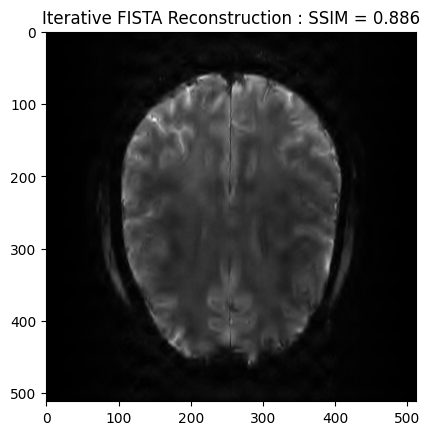

In [8]:
# Run the FISTA reconstruction and view results
image_rec, costs, metrics = reconstructor.reconstruct(
    kspace_data=kspace_obs,
    optimization_alg='fista',
    num_iterations=100,
)
image_rec = np.linalg.norm(image_rec, axis=0)
recon_ssim = ssim(image_rec, image)
plt.imshow(np.abs(image_rec), cmap='gray')
plt.title('Iterative FISTA Reconstruction : SSIM = ' + str(np.around(recon_ssim, 3)))
plt.show()

## POGM optimization

 - mu:  6e-08
 - lipschitz constant:  1.1
 - data:  (512, 512)
 - wavelet:  <mri.operators.linear.wavelet.WaveletN object at 0x795b2c947df0> - 4
 - max iterations:  100
 - image variable shape:  (32, 512, 512)
----------------------------------------
Starting optimization...


  0%|          | 0/100 [00:00<?, ?it/s]

 - final iteration number:  100
 - final log10 cost value:  6.0
 - converged:  False
Done.
Execution time:  105.65811157200005  seconds
----------------------------------------


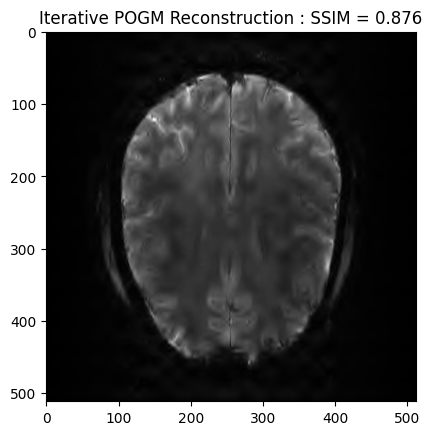

In [9]:
# Run the POGM reconstruction and view results
image_rec2, costs, metrics = reconstructor.reconstruct(
    kspace_data=kspace_obs,
    optimization_alg='pogm',
    num_iterations=100,
)
image_rec2 = np.linalg.norm(image_rec2, axis=0)
recon2_ssim = ssim(image_rec2, image)
plt.imshow(np.abs(image_rec2), cmap='gray')
plt.title('Iterative POGM Reconstruction : SSIM = ' + str(np.around(recon2_ssim, 3)))
plt.show()

In [10]:
# Setup the operators
linear_op = WaveletN(
    wavelet_name='sym8',
    nb_scale=4,
    n_coils=cartesian_ref_image.shape[0],
)
coeffs = linear_op.op(cartesian_ref_image)
regularizer_op = OWL(
    alpha=1.05e-8,
    beta=0,
    mode='band_based',
    n_coils=cartesian_ref_image.shape[0],
    bands_shape=linear_op.coeffs_shape,
)
# Setup Reconstructor
reconstructor = CalibrationlessReconstructor(
    fourier_op=fourier_op,
    linear_op=linear_op,
    regularizer_op=regularizer_op,
    gradient_formulation='synthesis',
    verbose=1,
)

Lipschitz constant is 1.0999998033046723


 - mu:  [<modopt.opt.proximity.OrderedWeightedL1Norm object at 0x795b2c87b6d0>, <modopt.opt.proximity.OrderedWeightedL1Norm object at 0x795b2c87b670>, <modopt.opt.proximity.OrderedWeightedL1Norm object at 0x795b2c87bca0>, <modopt.opt.proximity.OrderedWeightedL1Norm object at 0x795b5d0be9e0>, <modopt.opt.proximity.OrderedWeightedL1Norm object at 0x795b2c83a140>, <modopt.opt.proximity.OrderedWeightedL1Norm object at 0x795b2c83a350>, <modopt.opt.proximity.OrderedWeightedL1Norm object at 0x795b2c83a0b0>, <modopt.opt.proximity.OrderedWeightedL1Norm object at 0x795b2c83a0e0>, <modopt.opt.proximity.OrderedWeightedL1Norm object at 0x795b2c83a440>, <modopt.opt.proximity.OrderedWeightedL1Norm object at 0x795b2c83a410>, <modopt.opt.proximity.OrderedWeightedL1Norm object at 0x795b2c83a020>, <modopt.opt.proximity.OrderedWeightedL1Norm object at 0x795b2c83a260>, <modopt.opt.proximity.OrderedWeightedL1Norm object at 0x795b2c83a680>]
 - lipschitz constant:  1.0999998033046723
 - data:  (512, 512)
 - w

  0%|          | 0/100 [00:00<?, ?it/s]

 - final iteration number:  100
 - final log10 cost value:  6.0
 - converged:  False
Done.
Execution time:  195.9484668019977  seconds
----------------------------------------


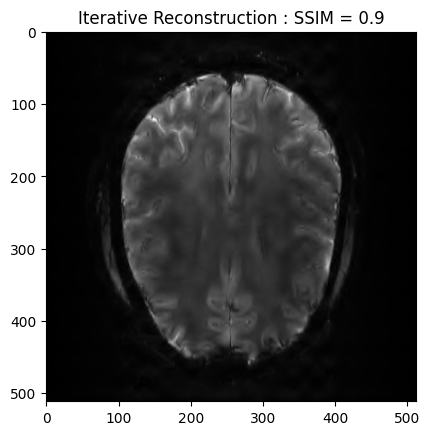

In [11]:
# Run the FISTA reconstruction and view results
image_rec, costs, metrics = reconstructor.reconstruct(
    kspace_data=kspace_obs,
    optimization_alg='fista',
    num_iterations=100,
)
image_rec = np.linalg.norm(image_rec, axis=0)
recon_ssim = ssim(image_rec, image)
plt.imshow(np.abs(image_rec), cmap='gray')
plt.title('Iterative Reconstruction : SSIM = ' + str(np.around(recon_ssim, 2)))
plt.show()

In [12]:
linear_op = WaveletN(
    wavelet_name='sym8',
    nb_scale=4,
    n_coils=cartesian_ref_image.shape[0],
)
regularizer_op = GroupLASSO(6e-8)

In [13]:
reconstructor = CalibrationlessReconstructor(
    fourier_op=fourier_op,
    linear_op=linear_op,
    regularizer_op=regularizer_op,
    gradient_formulation='analysis',
    verbose=1,
)

Lipschitz constant is 1.0999999344348907


 - mu:  6e-08
 - lipschitz constant:  1.0999999344348907
 - tau:  0.9523809730454954
 - sigma:  0.5
 - rho:  1.0
 - std:  None
 - 1/tau - sigma||L||^2 >= beta/2:  True
 - data:  (512, 512)
 - wavelet:  <mri.operators.linear.wavelet.WaveletN object at 0x795b2cd0d690> - 4
 - max iterations:  100
 - number of reweights:  0
 - primal variable shape:  (32, 512, 512)
 - dual variable shape:  (32, 291721)
----------------------------------------
Starting optimization...


  0%|          | 0/100 [00:00<?, ?it/s]

 - final iteration number:  100
 - final cost value:  1000000.0
 - converged:  False
Done.
Execution time:  98.07776652800021  seconds
----------------------------------------


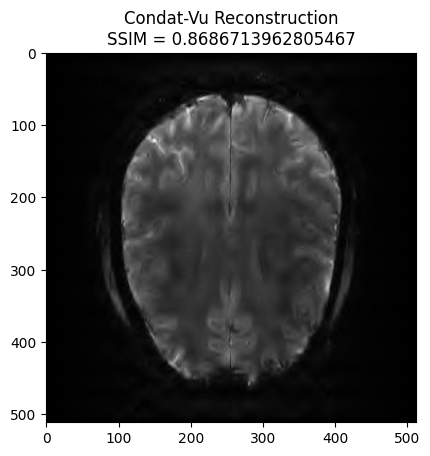

In [14]:
x_final, costs, metrics = reconstructor.reconstruct(
    kspace_data=kspace_obs,
    optimization_alg='condatvu',
    num_iterations=100,
)

image_rec = np.linalg.norm(x_final, axis=0)
recon_ssim = ssim(image_rec, image)

plt.imshow(np.abs(image_rec), cmap='gray')
plt.title('Condat-Vu Reconstruction\nSSIM = ' + str(recon_ssim))
plt.show()

In [15]:
coeffs = linear_op.op(cartesian_ref_image)
regularizer_op = OWL(
    alpha=1.05e-8,
    beta=0,
    mode='band_based',
    n_coils=cartesian_ref_image.shape[0],
    bands_shape=linear_op.coeffs_shape,
)

In [16]:
reconstructor = CalibrationlessReconstructor(
    fourier_op=fourier_op,
    linear_op=linear_op,
    regularizer_op=regularizer_op,
    gradient_formulation='analysis',
    verbose=1,
)

Lipschitz constant is 1.100000262260437


 - mu:  [<modopt.opt.proximity.OrderedWeightedL1Norm object at 0x795b2c772920>, <modopt.opt.proximity.OrderedWeightedL1Norm object at 0x795b2c751660>, <modopt.opt.proximity.OrderedWeightedL1Norm object at 0x795b2c7519f0>, <modopt.opt.proximity.OrderedWeightedL1Norm object at 0x795b2c99e020>, <modopt.opt.proximity.OrderedWeightedL1Norm object at 0x795b2c99e5f0>, <modopt.opt.proximity.OrderedWeightedL1Norm object at 0x795b2cd46c80>, <modopt.opt.proximity.OrderedWeightedL1Norm object at 0x795b2c9e9930>, <modopt.opt.proximity.OrderedWeightedL1Norm object at 0x795b2c9e96c0>, <modopt.opt.proximity.OrderedWeightedL1Norm object at 0x795b2c9eabc0>, <modopt.opt.proximity.OrderedWeightedL1Norm object at 0x795b2c8eb460>, <modopt.opt.proximity.OrderedWeightedL1Norm object at 0x795b2c8eb430>, <modopt.opt.proximity.OrderedWeightedL1Norm object at 0x795b2c8eb220>, <modopt.opt.proximity.OrderedWeightedL1Norm object at 0x795b2c8ebf70>]
 - lipschitz constant:  1.100000262260437
 - tau:  0.952380824371795

  0%|          | 0/100 [00:00<?, ?it/s]

 - final iteration number:  100
 - final cost value:  1000000.0
 - converged:  False
Done.
Execution time:  208.23918892000074  seconds
----------------------------------------


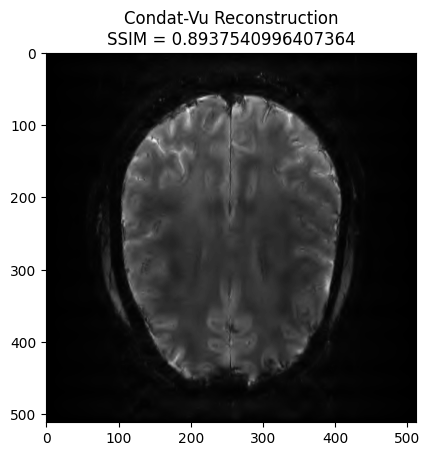

In [17]:
x_final, costs, metrics = reconstructor.reconstruct(
    kspace_data=kspace_obs,
    optimization_alg='condatvu',
    num_iterations=100,
)

image_rec = np.linalg.norm(x_final, axis=0)
recon_ssim = ssim(image_rec, image)

plt.imshow(np.abs(image_rec), cmap='gray')
plt.title('Condat-Vu Reconstruction\nSSIM = ' + str(recon_ssim))
plt.show()